# Example Code for using the $\partial I/ \partial V$ Fitting Routines

Import the needed packages to run the test script.

In [1]:
import qetpy as qp
import matplotlib.pyplot as plt
import numpy as np
import h5py

%matplotlib inline

Set all of the necessary parameters for initalizing the class, as well as specify the TES parameters that we will use to simulate a TES square wave response.

In [2]:
# Setting various parameters that are specific to the dataset
rsh = 5e-3
rbias_sg = 20000
fs = 625e3
sgfreq = 100
sgamp = 0.009381 / rbias_sg

rfb = 5000
loopgain = 2.4
drivergain = 4
adcpervolt = 65536 / 2
tracegain = rfb * loopgain * drivergain * adcpervolt

true_params = {
    'rsh': rsh,
    'rp': 0.006,
    'r0': 0.0756,
    'beta': 2,
    'l': 10,
    'L': 1e-7,
    'tau0': 500e-6,
    'gratio': 0.1,
    'tau3': 1e-2,
}

Make Simulated Data

In [3]:
psd_test = np.ones(int(4 * fs / sgfreq)) / tracegain**2 / 1e4
rawnoise = qp.gen_noise(psd_test, fs=fs, ntraces=300)

In [4]:
t = np.arange(rawnoise.shape[-1]) / fs
didv_response = qp.squarewaveresponse(
    t, sgamp, sgfreq, **true_params,
)
rawtraces = didv_response + rawnoise

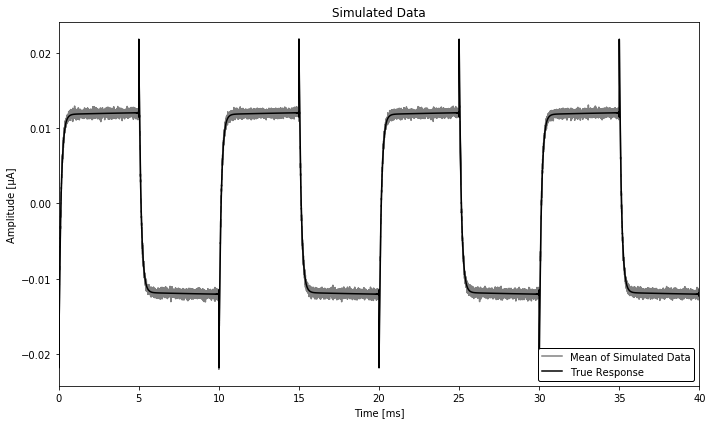

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    t * 1e3,
    rawtraces.mean(axis=0) * 1e6,
    color='gray',
    label='Mean of Simulated Data',
)
ax.plot(
    t * 1e3,
    didv_response * 1e6,
    color='k',
    label='True Response',
)
ax.set_ylabel('Amplitude [μA]')
ax.set_xlabel('Time [ms]')
ax.set_title('Simulated Data')
ax.set_xlim(0, 40)
ax.legend(loc='lower right', edgecolor='k', framealpha=1)
fig.tight_layout()

## Using the `DIDV` Class

Run the processing package on the data.

Note that the parameterization used by this class is such that there are no degenerate fitting parameters. Depending on the fit, the model changes.

From the Notes in `DIDV.dofit`:

    Notes
    -----
    Depending on the fit, there are three possible models to be
    used with different parameterizations:

    1-pole model
        - has the form:
            dV/dI = A * (1.0 + 2.0j * pi * freq * tau2)

    2-pole model
        - has the form:
            dV/dI = A * (1.0 + 2.0j * pi * freq * tau2)
                  + B / (1.0 + 2.0j * pi * freq * tau1)

    3-pole model
        - note the placement of the parentheses in the last term of
          this model, such that pole related to `C` is in the
          denominator of the `B` term
        - has the form: 
            dV/dI = A * (1.0 + 2.0j * pi * freq * tau2)
                  + B / (1.0 + 2.0j * pi * freq * tau1
                  - C / (1.0 + 2.0j * pi * freq * tau3))


In [6]:
didvfit = qp.DIDV(
    rawtraces,
    fs,
    sgfreq,
    sgamp,
    rsh,
    tracegain=1.0,
    r0=true_params['r0'], # the expected r0 should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    rp=true_params['rp'], # the expected rp should be specified if the estimated small-signal parameters are desired (otherwise they will be nonsensical)
    dt0=-1e-6, # a good estimate of the time shift value will likely speed up the fit/improve accuracy
    add180phase=False, # if the fits aren't working, set this to True to see if the square wave is off by half a period
)

# didvfit.dofit(1) # we skip the 1-pole fit, as it takes a long time to run due to being a bad model.
didvfit.dofit(2)
didvfit.dofit(3)

Let's look at the fit parameters for the fits.

In [7]:
result2 = didvfit.fitresult(2)
result3 = didvfit.fitresult(3)

Each of these `result` variables are dictionaries that contain various information that have to do with the fits, as shown by looking at the keys.

In [8]:
result3.keys()

dict_keys(['params', 'cov', 'errors', 'falltimes', 'cost', 'smallsignalparams'])

- `'params'` contains the fitted parameters from the minimization method (in the case of `DIDV`, this is in the parameterization used by the fitting algorithm)
- `'cov'` contains the corresponding covariance matrix
- `'errors'` is simply the square root of the diagonal of the covariance matrix
- `'falltimes'` contains the physical fall times of the specified model
- `'cost'` is the value of the chi-square at the fitted values
- `'smallsignalparams'` contains the corresponding parameters in the small-signal parameterization of the complex impedance, as shown by [Irwin and Hilton](https://doi.org/10.1007/10933596_3) for the two-pole model and [Maasilta](https://doi.org/10.1063/1.4759111) for the three-pole model.

We can also use `qetpy.complexadmittance` along with the `'smallsignalparams'` dictionary to quickly calculate the zero-frequency component of the $\partial I / \partial V$.

In [9]:
print(f"The 2-pole dI/dV(0) is: {qp.complexadmittance(0, **result2['smallsignalparams']).real:.2f}")
print(f"The 3-pole dI/dV(0) is: {qp.complexadmittance(0, **result3['smallsignalparams']).real:.2f}")

The 2-pole dI/dV(0) is: -10.19
The 3-pole dI/dV(0) is: -10.71


There are a handful of plotting functions that can be used to plot the results, where we use two of them below.

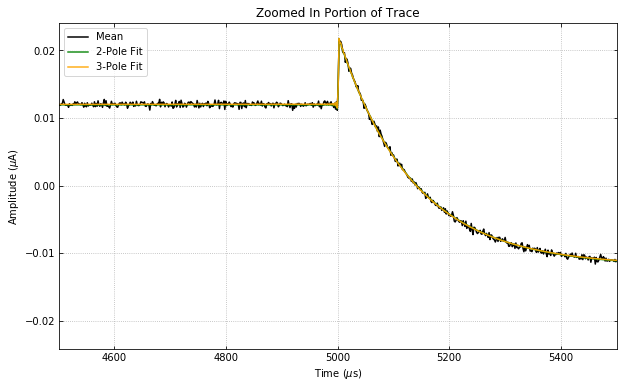

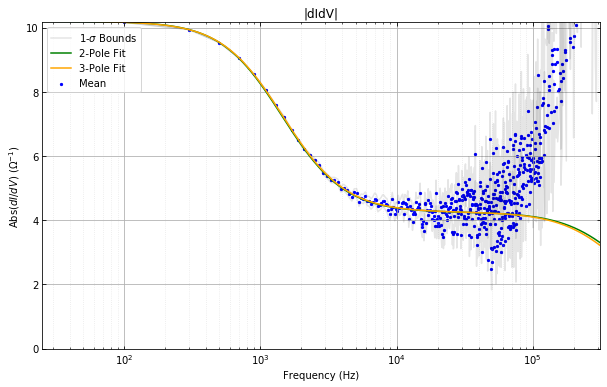

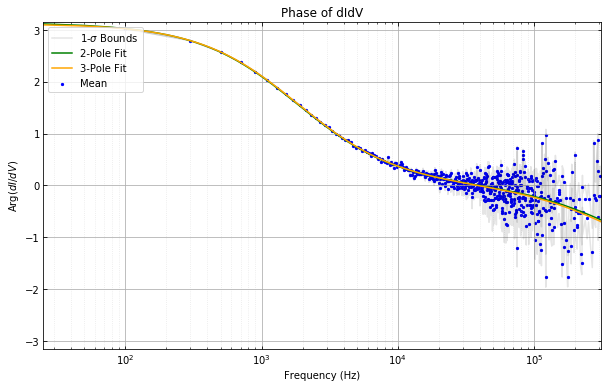

In [10]:
# didvfit.plot_full_trace()
# didvfit.plot_single_period_of_trace()
# didvfit.plot_didv_flipped()
# didvfit.plot_re_im_didv()

didvfit.plot_zoomed_in_trace(zoomfactor=0.1)
didvfit.plot_abs_phase_didv()

## Advanced Usage: Using `DIDVPriors`

There is a separate class, which uses the small-signal parameterization to do the fitting. However, the small-signal parameterization has more parameters than degrees of freedom, resulting in degeneracy in the model (as opposed to the models used by `DIDV`, which are non-degenerate). However, if the uncertainties on the small-signal parameters are desired, then the `DIDVPriors` class is recommended, which uses a prior probability distribution on known values to remove the degeneracies.

The initialization of the class is quite similar.

In [11]:
didvfitprior = qp.DIDVPriors(
    rawtraces,
    fs,
    sgfreq,
    sgamp,
    rsh,
    tracegain=1.0,
    dt0=-18.8e-6,
)

Running the fit requires more information, as we need to know the prior probability distribution. In this case, `priors` and `priorscov` are additionally required in the `dofit` method.

- `priors` is a 1-d ndarray that contains the prior known values of the specified model.
- `priorscov` is a 2-d ndarray that contains the corresponding covariance matrix of the values in `priors`
    - For any values that are not known, the corresponding elements should be set to zero for both `priors` and `priorscov`.

The values of `priors` and `priorscov` for each model are:
- 1-pole
    - `priors` is a 1-d array of length 4 containing (`rsh`, `rp`, `L`, `dt`) **(in that order!)**
    - `priorscov` is a 2-d array of shape (4, 4) containing the corresponding covariance matrix
- 2-pole
    - `priors` is a 1-d array of length 8 containing (`rsh`, `rp`, `r0`, `beta`, `l`, `L`, `tau0`, `dt`) **(in that order!)**
    - `priorscov` is a 2-d array of shape (8, 8) containing the corresponding covariance matrix
- 1-pole
    - `priors` is a 1-d array of length 10 containing (`rsh`, `rp`, `r0`, `beta`, `l`, `L`, `tau0`, `gratio`, `tau3`, `dt`) **(in that order!)**
    - `priorscov` is a 2-d array of shape (10, 10) containing the corresponding covariance matrix

We note that, the more parameters passed to the fitting algorithm, the 'better' the result will be, as degeneracies will be removed.

At minimum, we recommend passing `rsh`, `rp`, and `r0` (the last of which should not be passed to the 1-pole fit).

Below, we show an example of using the fitting algorithm for the 3-pole case, assuming 10% errors on `rsh`, `rp`, and `r0`.

In [12]:
priors = np.zeros(10)
priorscov = np.zeros((10, 10))

priors[0] = true_params['rsh']
priorscov[0, 0] = (0.1 * priors[0])**2
priors[1] = true_params['rp']
priorscov[1, 1] = (0.1 * priors[1])**2
priors[2] = true_params['r0']
priorscov[2, 2] = (0.1 * priors[2])**2

didvfitprior.dofit(3, priors, priorscov)

Extracting the results of the fit is very similar, where a dictionary is returned, which has slightly different form than `DIDV`.

In [13]:
result3_priors = didvfitprior.fitresult(3)
result3_priors.keys()

dict_keys(['params', 'cov', 'errors', 'falltimes', 'cost', 'priors', 'priorscov'])

- `'params'` contains the fitted parameters from the minimization method (which are the small-signal parameters), as shown by [Irwin and Hilton](https://doi.org/10.1007/10933596_3) for the two-pole model and [Maasilta](https://doi.org/10.1063/1.4759111) for the three-pole model.
- `'cov'` contains the corresponding covariance matrix
- `'errors'` is simply the square root of the diagonal of the covariance matrix
- `'falltimes'` contains the physical fall times of the specified model
- `'cost'` is the value of the chi-square at the fitted values
- `'priors'` simply contains the inputted priors
- `'priorscov'` simply contains the inputted priors covariance matrix

Note the lack of `smallsignalparams`, as compared to `DIDV`. Since we fit directly using the small-signal parameterization, there is no need to convert parameters.

We can again calculate  the zero-frequency component of the $\partial I / \partial V$ using `qetpy.complexadmittance`, this time using the `'params'` key in the results dictionary.

In [14]:
print(f"The 3-pole dI/dV(0) is: {qp.complexadmittance(0, **result3_priors['params']).real:.2f}")

The 3-pole dI/dV(0) is: -10.71


This class uses the same plotting functions as `DIDV`, such that they can be called in the same way.

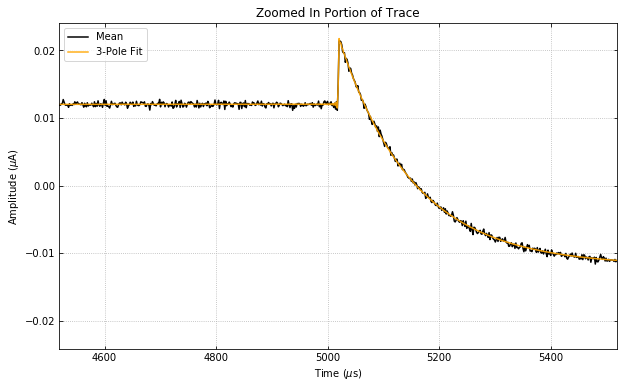

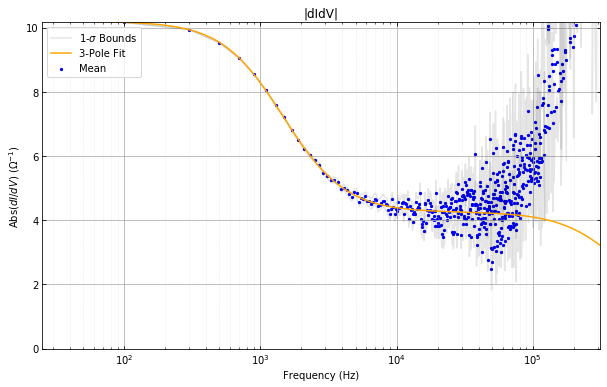

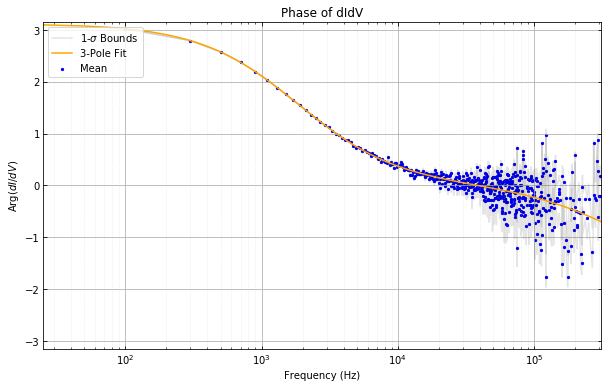

In [15]:
didvfitprior.plot_zoomed_in_trace(zoomfactor=0.1)
didvfitprior.plot_abs_phase_didv()